# Lichess Rating Projection Tool (Interactive Version)

This interactive notebook allows you to:
- Enter your Lichess username and select rating format through user-friendly widgets
- Fetch rating data from Lichess API
- Analyze rating trends using polynomial regression
- Predict future ratings and estimate when you'll reach target ratings

## How to use:
1. Run the first cell to set up the interactive input widgets
2. Enter your username and select rating format
3. Click "Fetch Rating Data" button
4. Run the subsequent cells for analysis and predictions

---

In [14]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import fsolve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Import widgets for interactive input
import ipywidgets as widgets
from IPython.display import display, clear_output

# ===============================
# Interactive User Input Section
# ===============================

print("Welcome to the Lichess Rating Analysis System")
print("Please enter your details below:")
print()

# Create input widgets
username_widget = widgets.Text(
    value='',
    placeholder='Enter your Lichess username',
    description='Username:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

format_widget = widgets.Dropdown(
    options=['Bullet', 'Blitz', 'Rapid', 'Classical', 'Correspondence'],
    value='Bullet',
    description='Rating Format:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

fetch_button = widgets.Button(
    description='Fetch Rating Data',
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

output_area = widgets.Output()

# Global variables to store data
username = None
rating_format = None
df = None
filename = None
best_model = None
best_poly_features = None

def fetch_data(button):
    global username, rating_format, df, filename
    
    with output_area:
        clear_output(wait=True)
        
        # Get user inputs
        username = username_widget.value.strip()
        selected_format = format_widget.value
        
        if not username:
            print("Error: Please enter a valid username!")
            return
        
        print(f"Fetching {selected_format} rating data for user: {username}...")
        
        # API endpoint for rating history
        url = f"https://lichess.org/api/user/{username}/rating-history"
        
        try:
            # Send GET request
            response = requests.get(url)
            
            # Check if the request was successful
            if response.status_code == 200:
                data = response.json()
                
                # Find the selected rating format
                rating_format = None
                for item in data:
                    if item["name"] == selected_format:
                        rating_format = item
                        break
                
                if not rating_format:
                    print(f"No {selected_format} rating data found for user {username}")
                    available_formats = [item["name"] for item in data if item["points"]]
                    if available_formats:
                        print(f"Available formats: {', '.join(available_formats)}")
                    return
                
                if not rating_format["points"]:
                    print(f"No rating history found for {selected_format} format")
                    return
                
                # Extract dates and ratings
                dates = [datetime(year=entry[0], month=entry[1] + 1, day=entry[2]) for entry in rating_format["points"]]
                ratings = [entry[3] for entry in rating_format["points"]]
                
                # Save data to CSV dynamically based on the selected rating format
                filename = f"lichess_{rating_format['name'].lower()}_ratings_{username}.csv"
                with open(filename, "w") as f:
                    f.write("Date,Rating\n")
                    for date, rating in zip(dates, ratings):
                        f.write(f"{date.strftime('%Y-%m-%d')},{rating}\n")
                
                print(f"Rating history saved to {filename}")
                print(f"Found {len(ratings)} rating data points")
                print(f"Date range: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")
                print(f"Rating range: {min(ratings)} to {max(ratings)}")
                print()
                print("Data fetched successfully! You can now run the analysis cells below.")
                
            else:
                print(f"Failed to fetch data. Status code: {response.status_code}")
                if response.status_code == 404:
                    print("User not found. Please check the username.")
                    
        except Exception as e:
            print(f"Error occurred: {str(e)}")

# Connect button to function
fetch_button.on_click(fetch_data)

# Display widgets
display(username_widget)
display(format_widget)
display(fetch_button)
display(output_area)

Welcome to the Lichess Rating Analysis System
Please enter your details below:



Text(value='', description='Username:', layout=Layout(width='400px'), placeholder='Enter your Lichess username…

Dropdown(description='Rating Format:', layout=Layout(width='400px'), options=('Bullet', 'Blitz', 'Rapid', 'Cla…

Button(button_style='primary', description='Fetch Rating Data', layout=Layout(width='200px'), style=ButtonStyl…

Output()

In [15]:
# ===============================
# Data Loading and Preprocessing
# ===============================

# Check if data has been fetched
if filename is None:
    print("Error: Please fetch data first using the widgets above!")
else:
    # Load Data dynamically based on the selected rating format
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"], format="mixed", dayfirst=True)  # Ensure proper date format
    df = df.sort_values(by="Date")  # Sort data chronologically
    
    # Convert date to numerical format (days since first recorded game)
    df["Days"] = (df["Date"] - df["Date"].min()).dt.days
    
    # Split Data into Training & Testing Sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(df["Days"].values.reshape(-1, 1), df["Rating"], test_size=0.2, shuffle=False)
    
    print(f"Data loaded successfully!")
    print(f"Total data points: {len(df)}")
    print(f"Training set: {len(X_train)} points")
    print(f"Testing set: {len(X_test)} points")
    print(f"Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
    print(f"Rating range: {df['Rating'].min()} to {df['Rating'].max()}")

Data loaded successfully!
Total data points: 843
Training set: 674 points
Testing set: 169 points
Date range: 2020-08-24 to 2025-08-11
Rating range: 2063 to 2871


In [16]:
# ===============================
# Polynomial Regression Model Training
# ===============================

global best_model, best_poly_features

if df is None:
    print("Error: Please load data first!")
else:
    global best_model, best_poly_features
    
    # Test different polynomial degrees to find the best fit
    degrees = range(1, 6)  # Test degrees 1 to 5
    mse_scores = []
    models = {}
    
    for degree in degrees:
        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train)
        X_test_poly = poly_features.transform(X_test)
        
        # Train linear regression model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_poly)
        
        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
        
        # Store model and polynomial features
        models[degree] = {'model': model, 'poly_features': poly_features, 'mse': mse}
    
    # Find the best degree (lowest MSE)
    best_degree = degrees[np.argmin(mse_scores)]
    best_model = models[best_degree]['model']
    best_poly_features = models[best_degree]['poly_features']
    
    print(f"Best Polynomial Degree: {best_degree} (MSE: {models[best_degree]['mse']:.2f})")
    
    # Display MSE for all degrees
    print("\nMSE Scores for different polynomial degrees:")
    for degree, mse in zip(degrees, mse_scores):
        print(f"   Degree {degree}: {mse:.2f}")

Best Polynomial Degree: 3 (MSE: 3438.79)

MSE Scores for different polynomial degrees:
   Degree 1: 3663.20
   Degree 2: 11250.99
   Degree 3: 3438.79
   Degree 4: 206754.06
   Degree 5: 1022614.27


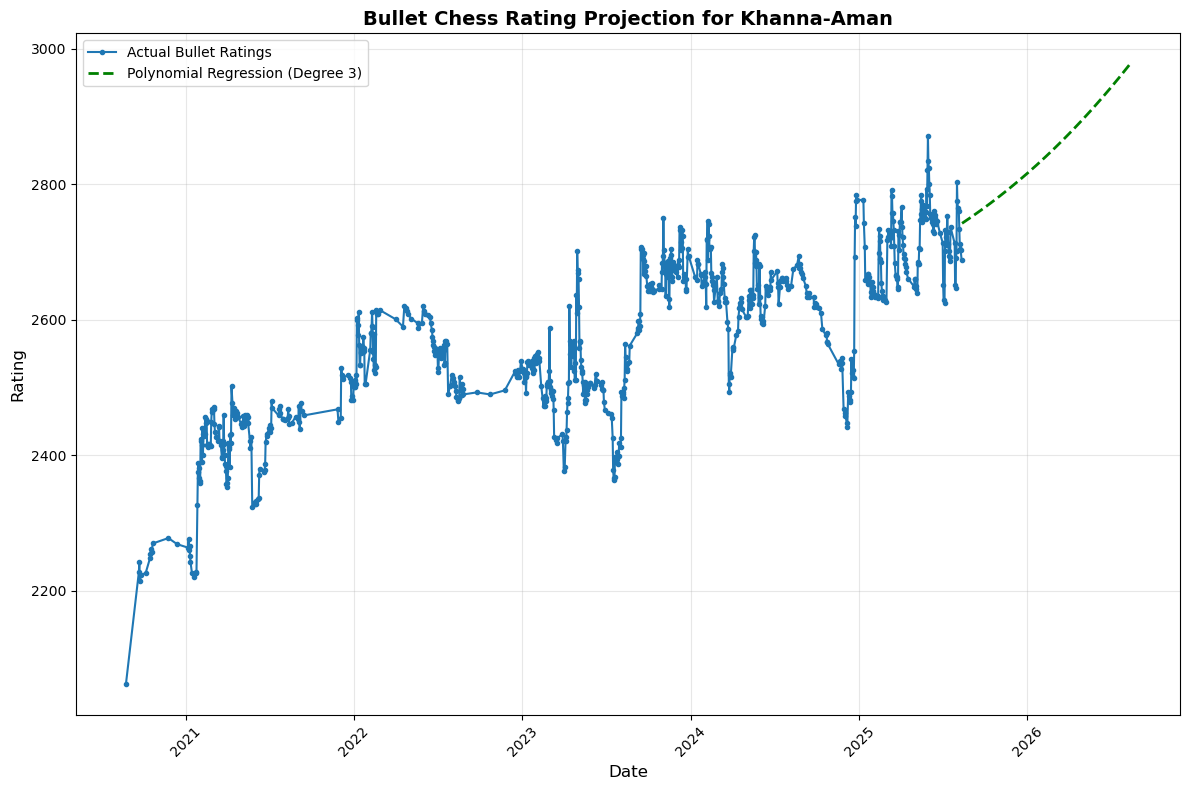

Visualization complete!
Showing predictions for the next 365 days
Current rating: 2689
Predicted rating in 1 year: 2977


In [17]:
# ===============================
# Rating History Visualization and Predictions
# ===============================

if df is None or best_model is None or best_poly_features is None:
    print("Error: Please run the previous cells first!")
else:
    # Create future predictions (next 365 days)
    future_days = np.arange(df["Days"].max() + 1, df["Days"].max() + 366)
    future_days_poly = best_poly_features.transform(future_days.reshape(-1, 1))
    predicted_ratings = best_model.predict(future_days_poly)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot actual rating history
    plt.plot(df["Date"], df["Rating"], label=f"Actual {rating_format['name']} Ratings", marker="o", markersize=3)
    
    # Plot future predictions
    future_dates = df["Date"].min() + pd.to_timedelta(future_days, unit='D')
    plt.plot(future_dates, predicted_ratings, 
             label=f"Polynomial Regression (Degree {best_degree})", linestyle="dashed", color="green", linewidth=2)
    
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Rating", fontsize=12)
    plt.legend(fontsize=10)
    plt.title(f"{rating_format['name']} Chess Rating Projection for {username}", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Visualization complete!")
    print(f"Showing predictions for the next 365 days")
    print(f"Current rating: {df['Rating'].iloc[-1]}")
    print(f"Predicted rating in 1 year: {predicted_ratings[-1]:.0f}")

In [18]:
# ===============================
# Prediction Functions
# ===============================

def predict_rating(target_date):
    """
    Predicts the rating for a given future date.
    User should enter the target date in 'dd-mm-yyyy' format.
    """
    global df, best_model, best_poly_features
    if df is None or best_model is None or best_poly_features is None:
        return "Error: Please run the data processing and model training cells first!"
    
    try:
        target_days = (pd.to_datetime(target_date, dayfirst=True) - df["Date"].min()).days
        
        if target_days <= df["Days"].max():
            return "Date must be in the future."
        
        # Transform the target days using polynomial features
        target_days_poly = best_poly_features.transform([[target_days]])
        predicted_rating = best_model.predict(target_days_poly)[0]
        
        return f"{predicted_rating:.2f}"
    except Exception as e:
        return f"Error: {str(e)}. Please use dd-mm-yyyy format."

def when_will_i_reach(target_rating):
    """
    Estimates when a certain rating will be reached.
    """
    global df, best_model, best_poly_features
    if df is None or best_model is None or best_poly_features is None:
        return "Error: Please run the data processing and model training cells first!"
    
    try:
        target_rating = float(target_rating)
        current_rating = df['Rating'].iloc[-1]
        
        
        if target_rating <= current_rating:
            return "You have already achieved or surpassed this rating!"
        
        # Simple approach: try different future time points until we find the target
        max_days = df['Days'].max()
        
        # First, let's check what the model predicts for 6 months and 1 year
        test_6m = max_days + 180
        test_1y = max_days + 365
        
        pred_6m_poly = best_poly_features.transform([[test_6m]])
        pred_1y_poly = best_poly_features.transform([[test_1y]])
        pred_6m = best_model.predict(pred_6m_poly)[0]
        pred_1y = best_model.predict(pred_1y_poly)[0]
        
        
        # If target is higher than 1-year prediction, it will take longer
        if target_rating > pred_1y:
            return "Based on the current trend, reaching this rating may take more than 1 year."
        
        # Search with finer granularity - every 7 days for first year
        for days_ahead in range(7, 366, 7):  # Check every week for first year
            test_days = max_days + days_ahead
            test_days_poly = best_poly_features.transform([[test_days]])
            predicted_rating = best_model.predict(test_days_poly)[0]
            
            if predicted_rating >= target_rating:
                target_date = df['Date'].min() + pd.to_timedelta(test_days, unit='D')
                return target_date.strftime('%d-%m-%Y')
        
        # If not found in first year, check monthly for next few years
        for days_ahead in range(365, 1825, 30):  # Check monthly for next 4 years
            test_days = max_days + days_ahead
            test_days_poly = best_poly_features.transform([[test_days]])
            predicted_rating = best_model.predict(test_days_poly)[0]
            
            if predicted_rating >= target_rating:
                target_date = df['Date'].min() + pd.to_timedelta(test_days, unit='D')
                return target_date.strftime('%d-%m-%Y')
        
        return "Based on the current trend, reaching this rating may take more than 5 years."
            
    except Exception as e:
        return f"Error calculating target date. Please ensure you entered a valid rating number."

print("Prediction functions loaded successfully!")
print("You can now use the interactive prediction widgets below.")

Prediction functions loaded successfully!
You can now use the interactive prediction widgets below.


In [19]:
# ===============================
# Interactive Prediction Widgets
# ===============================

if df is None:
    print("Please fetch and process data first!")
else:
    print("Interactive Rating Predictions")
    print("=" * 40)
    
    # Date prediction widget
    date_input = widgets.Text(
        value='01-01-2026',
        placeholder='dd-mm-yyyy',
        description='Target Date:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    
    predict_date_button = widgets.Button(
        description='Predict Rating',
        button_style='info',
        layout=widgets.Layout(width='150px')
    )
    
    date_output = widgets.Output()
    
    def on_predict_date_click(button):
        with date_output:
            clear_output(wait=True)
            target_date = date_input.value
            result = predict_rating(target_date)
            print(f"Estimated rating on {target_date}: {result}")
    
    predict_date_button.on_click(on_predict_date_click)
    
    # Rating target widget
    rating_input = widgets.IntText(
        value=int(df['Rating'].iloc[-1] + 100),  # Default to current rating + 100
        description='Target Rating:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    
    predict_rating_button = widgets.Button(
        description='When Will I Reach?',
        button_style='success',
        layout=widgets.Layout(width='150px')
    )
    
    rating_output = widgets.Output()
    
    def on_predict_rating_click(button):
        with rating_output:
            clear_output(wait=True)
            target_rating = rating_input.value
            result = when_will_i_reach(target_rating)
            print(f"Estimated date to reach {target_rating} rating: {result}")
    
    predict_rating_button.on_click(on_predict_rating_click)
    
    # Display widgets
    print("\nPredict Rating for a Specific Date:")
    display(widgets.HBox([date_input, predict_date_button]))
    display(date_output)
    
    print("\nEstimate When You'll Reach a Target Rating:")
    display(widgets.HBox([rating_input, predict_rating_button]))
    display(rating_output)
    
    # Show some example predictions
    print("\nQuick Stats:")
    print(f"Current rating: {df['Rating'].iloc[-1]}")
    
    # Only show predictions if model is trained
    if best_model is not None and best_poly_features is not None:
        print(f"Predicted rating in 6 months: {predict_rating((datetime.now() + pd.DateOffset(months=6)).strftime('%d-%m-%Y'))}")
        print(f"Predicted rating in 1 year: {predict_rating((datetime.now() + pd.DateOffset(years=1)).strftime('%d-%m-%Y'))}")
    else:
        print("Predicted rating in 6 months: Please run the model training cell first!")
        print("Predicted rating in 1 year: Please run the model training cell first!")

Interactive Rating Predictions

Predict Rating for a Specific Date:


Output()


Estimate When You'll Reach a Target Rating:


Output()


Quick Stats:
Current rating: 2689
Predicted rating in 6 months: 2841.83
Predicted rating in 1 year: 2977.22
